# Monte Carlo Justificaction

## MoSDeF Cassandra

In [13]:
import mbuild
import foyer
import mosdef_cassandra as mc
import unyt as u

# Use mbuild to create a methane
adsorbate = mbuild.Compound(name="Ar")

# Create an empty mbuild.Box
box = mbuild.Box(lengths=[3., 3., 3.])

# Load force field
ff = foyer.Forcefield("../../Resources/foyer/noble_gas.xml")

# Use foyer to apply the force field
adsorbate_ff = ff.apply(adsorbate)

# Create box and species list
box_list = [box]
species_list = [adsorbate_ff]

mols_to_add = [[64]]

system = mc.System(box_list, species_list, mols_to_add=mols_to_add)
moveset = mc.MoveSet("gcmc", species_list)

custom_args = {
    "chemical_potentials": [-9.5 * (u.kJ / u.mol)],
    "prop_freq": 64,
    'vdw_cutoff': 14.0 * u.angstrom,
    'charge_style': "none"
}

mc.run(
    system=system,
    moveset=moveset,
    run_type="equilibration",
    run_length=64000,
    temperature=100.0 * u.K,
    **custom_args,
)

/home/woodrowwilson/Programs/miniconda3/lib/python3.9/site-packages/parmed/openmm/topsystem.py:240: OpenMMWarning: Adding what seems to be Urey-Bradley terms before Angles. This is unexpected, but the parameters will all be present in one form or another.
  warnings.warn('Adding what seems to be Urey-Bradley terms before ' # pragma: no cover


Using the following executables for Cassandra:
Python: /home/woodrowwilson/Programs/miniconda3/bin/python
library_setup: /home/woodrowwilson/Programs/cassandra/1.2.6/Exe/library_setup.py
Cassandra: /home/woodrowwilson/Programs/cassandra/1.2.6/Exe/cassandra.exe
Generating fragment libraries...
Running Cassandra...


## ASE-LJ

In [3]:
from ase import Atoms
from ase.calculators.lj import LennardJones
from ase.calculators.cp2k import CP2K
from ase.mc import GCMC
from ase.units import kJ, mol, kB
import numpy as np


def myLJ():
    return LennardJones(sigma=3.41, epsilon=119.8 * kB, rc=14.0)


species0 = Atoms("Ar", [[0, 0, 0]])

vol = 7.5
species0.set_cell((vol, vol, vol))
species0.center()

species_list = [species0]

atoms = species0.repeat((4, 4, 4))
atoms.set_pbc(True)

tag = -1
tags = []
for atom in atoms:
    if atom.index % 1 == 0:
        tag += 1
        tags.append(tag)
    atom.tag = tag

species_tags = []
species_tags.append(tags)

atoms.calc = myLJ()


mc = GCMC(
    atoms=atoms,
    species=species_list,
    species_tags=species_tags,
    temperature_K=100,
    chemical_potential=np.array([-9.5]) * kJ / mol,
    calc_function=myLJ,
    thermal_interval=1000,
    logfile="mc-lj.log",
    trajectory="mc-lj.traj",
    loginterval=len(tags),
)

mc.run(1000 * len(tags))


True

## ASE-CP2K

In [22]:
from ase import Atoms
from ase.calculators.cp2k import CP2K
from ase.mc import GCMC
from ase.units import kJ, mol, kB
import numpy as np


def myCP2K():
    inp = """
&FORCE_EVAL
&DFT

&SCF
&OUTER_SCF .TRUE.
MAX_SCF 20
&END OUTER_SCF
&OT .TRUE.
MINIMIZER DIIS
PRECONDITIONER FULL_SINGLE_INVERSE
&END OT
&END SCF

&XC

&XC_GRID
XC_DERIV NN10_SMOOTH
XC_SMOOTH_RHO NN10
&END XC_GRID

&XC_FUNCTIONAL
&GGA_X_RPW86
&END GGA_X_RPW86
&GGA_C_PBE
&END GGA_C_PBE
&END XC_FUNCTIONAL
&vdW_POTENTIAL
DISPERSION_FUNCTIONAL NON_LOCAL
&NON_LOCAL
TYPE RVV10
VERBOSE_OUTPUT
KERNEL_FILE_NAME rVV10_kernel_table.dat
&END NON_LOCAL
&END vdW_POTENTIAL

&END
&END
&END
    """
    return CP2K(xc=None, inp=inp, command="cp2k_shell.ssmp")


species0 = Atoms("Ar", [[0, 0, 0]])

vol = 7.5
species0.set_cell((vol, vol, vol))
species0.center()

species_list = [species0]

atoms = species0.repeat((1, 1, 1))
atoms.set_pbc(True)


tag = -1
tags = []
atoms_per_molecule = len(species0)
for atom in atoms:
    if atom.index % atoms_per_molecule == 0:
        tag += 1
        tags.append(tag)
    atom.tag = tag

species_tags = []
species_tags.append(tags)

atoms.calc = myCP2K()

'''
mc = GCMC(
    atoms=atoms,
    species=species_list,
    species_tags=species_tags,
    temperature_K=100,
    chemical_potential=np.array([-9.5]) * kJ / mol,
    calc_function=myCP2K,
    thermal_interval=len(tags),
    logfile="mc-cp2k.log",
    trajectory="mc-cp2k.traj",
    loginterval=len(tags),
)

mc.run(1000 * len(tags))
'''


Program received signal SIGABRT: Process abort signal.

Backtrace for this error:
#0  0x7f41e7c23ad0 in ???
#1  0x7f41e7c22c35 in ???
#2  0x7f41e784251f in ???
#3  0x7f41e7896a7c in ???
#4  0x7f41e7842475 in ???
#5  0x7f41e78287f2 in ???
#6  0x559e72c44b18 in __message_passing_MOD_mp_abort
	at /home/woodrowwilson/Programs/cp2k/2022.1/src/mpiwrap/message_passing.F:1077
#7  0x559e72c45a17 in __base_hooks_MOD_cp_abort
	at /home/woodrowwilson/Programs/cp2k/2022.1/src/base/base_hooks.F:76
#8  0x559e728d8fd7 in __input_parsing_MOD_section_vals_parse
	at /home/woodrowwilson/Programs/cp2k/2022.1/src/input/input_parsing.F:189
#9  0x559e728d89b8 in __input_parsing_MOD_section_vals_parse
	at /home/woodrowwilson/Programs/cp2k/2022.1/src/input/input_parsing.F:172
#10  0x559e728d89b8 in __input_parsing_MOD_section_vals_parse
	at /home/woodrowwilson/Programs/cp2k/2022.1/src/input/input_parsing.F:172
#11  0x559e70da875e in __input_cp2k_read_MOD_read_input
	at /home/woodrowwilson/Programs/cp2k/2022.1/

ValueError: invalid literal for int() with base 10: ''

# Analysis

In [1]:
import pandas as pd
from ase.io.trajectory import Trajectory
import numpy as np

def read_cassandra_prp(filename):
    with open(filename) as fh:
        #First line
        fh.readline()
        #Secondline
        column_names = fh.readline().split()
        del column_names[0]
    
    return pd.read_table(filename, skiprows=3, names=column_names, delim_whitespace=True)

def read_ase_trajectory(filename):
    traj = Trajectory(filename, mode="r")
    natoms = []
    for atoms in traj:
        natoms.append(len(atoms))
    return np.array(natoms)
    
natoms_cassandra = read_cassandra_prp("gcmc.out.prp")["Nmols"]
natoms_ase_lj = read_ase_trajectory("mc-lj.traj")
natoms_ase_cp2k = read_ase_trajectory("HPC/mc-cp2k.traj")

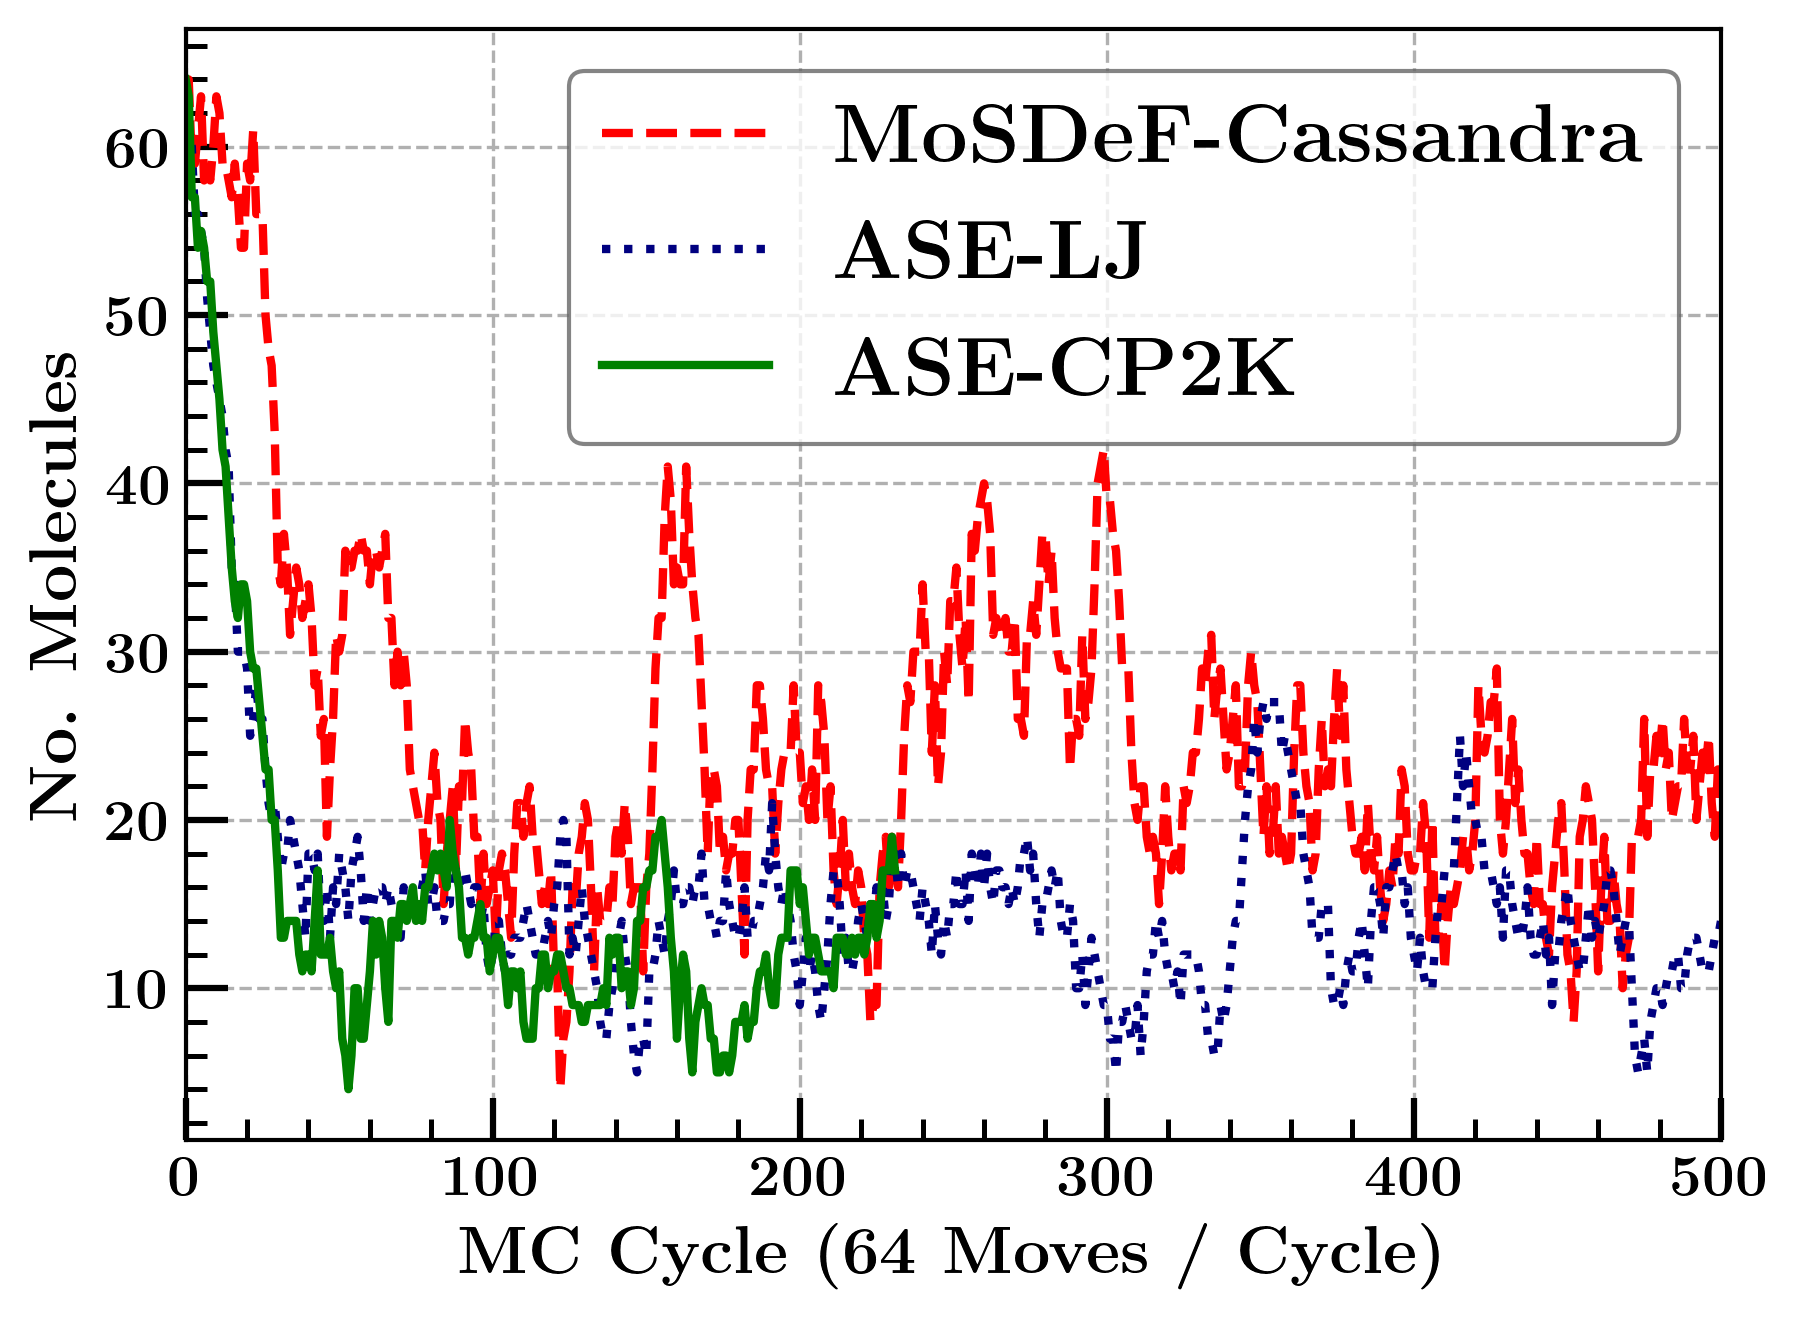

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(natoms_cassandra, color="red", linestyle="--", label=r" \bf MoSDeF-Cassandra")
plt.plot(natoms_ase_lj, color="navy", linestyle=":", label=r" \bf ASE-LJ")
plt.plot(natoms_ase_cp2k, color="green", linestyle="solid", label=r"\bf ASE-CP2K")
plt.xlabel(r'\bf MC Cycle (64 Moves / Cycle)')
plt.ylabel(r'\bf No. Molecules')
#plt.title(r'\bf Argon GCMC (T = 100 K ; $\mu$ = -9.5 kJ/mol)')
plt.xlim((0,500))
plt.legend()
plt.tight_layout()
plt.savefig("mc-comparison.png")
plt.show()